In [ ]:
import tensorflow as tf
import numpy as np
import os
import cv2
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def get_images(link_to_dataset):
    IMG_WIDTH=224
    IMG_HEIGHT=224
    img_data_2D =[]
    class_ =[]
    nd_image_array =[]

    for folder in os.listdir(link_to_dataset):
        for file in os.listdir(os.path.join(link_to_dataset,folder)):
            image_path = os.path.join(link_to_dataset, folder, file)
            image = Image.open(image_path).resize((IMG_WIDTH,IMG_HEIGHT)).convert('RGB')
            # convert image to numpy array
            image_data = np.array(image)
            image_ = np.array(image)
            flat_image= image_.flatten()
            #image = image.astype('float32')
            
            class_.append(folder)
            img_data_2D.append(flat_image)
            nd_image_array.append(image_data)

            # for i in range(5):
            #     #img=mpimg.imread(image)
            #     ax=plt.subplot(1,5,i+1)
            #     ax.title.set_text(file)
    plt.imshow(image)

    return class_, img_data_2D, nd_image_array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


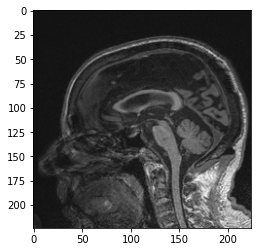

In [12]:
class_names_,img_data_, images_array = get_images(r'/content/drive/MyDrive/datasets/Brain')

In [ ]:
y_ = np.array(class_names_)
le = preprocessing.LabelEncoder()
y = le.fit_transform(y_)
y

In [14]:
X_ = np.array(images_array)
X_.shape

(410, 224, 224, 3)

In [15]:
X_,y = shuffle(X_, y, random_state=32)

Data Preprocessing
I will use data augmentation to bring out various variations of a given image to give the model a wider array of training examples for better generalization
We will use:
rotations -  randomly gives different rotations of one image
flips -randomly flips half of the images horizontally or vertically
colour contrast
zoom_range - randomly zooms inside the images
width_shift_range - different ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
heigh_shift_range
and fill_mode to fill up any spaces that may have been created during the augmentation process




In [16]:
y_cat_ = tf.keras.utils.to_categorical(y, num_classes=1000)
y_cat_

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_cat_, test_size=0.20)

In [18]:
X_train_.shape

(328, 224, 224, 3)

In [19]:
#augment the images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
                                   zoom_range=0.15,
                                   horizontal_flip = True,
                                   vertical_flip =True,
                                   rotation_range=40, 
                                   brightness_range = [0.8,1.5],
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   fill_mode='nearest'
                                   )


In [20]:
mobilenet_model = tf.keras.applications.mobilenet.MobileNet(
    input_shape=None, alpha=1.0, depth_multiplier=1, dropout=0.001,
    include_top=True, weights='imagenet', input_tensor=None, pooling=None,
    classes=1000, classifier_activation='softmax'
)

17235968/17225924 [==============================] - 0s 0us/step


In [54]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.001,
     beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

In [31]:
mobilenet_model.compile(loss='CategoricalCrossentropy',
              optimizer= Adam,
              metrics=['accuracy'])

In [ ]:
mobilenet_model.summary()

In [32]:
mobilenet_model.fit(train_datagen.flow(X_train_, y_train_, batch_size = 32),validation_data=(X_test_, y_test_), steps_per_epoch = len(X_train_)//32, 
              epochs = 10)

Epoch 1/10
10/10 [==============================] - 7s 466ms/step - loss: 0.1314 - accuracy: 0.9628 - val_loss: 16.2937 - val_accuracy: 0.4512
Epoch 2/10
10/10 [==============================] - 4s 406ms/step - loss: 0.1200 - accuracy: 0.9730 - val_loss: 12.0832 - val_accuracy: 0.4512
Epoch 3/10
10/10 [==============================] - 4s 406ms/step - loss: 0.0991 - accuracy: 0.9662 - val_loss: 11.3920 - val_accuracy: 0.4512
Epoch 4/10
10/10 [==============================] - 4s 405ms/step - loss: 0.1153 - accuracy: 0.9561 - val_loss: 15.3483 - val_accuracy: 0.4512
Epoch 5/10
10/10 [==============================] - 4s 409ms/step - loss: 0.0362 - accuracy: 0.9932 - val_loss: 11.8836 - val_accuracy: 0.4512
Epoch 6/10
10/10 [==============================] - 4s 410ms/step - loss: 0.0605 - accuracy: 0.9764 - val_loss: 7.2201 - val_accuracy: 0.5122
Epoch 7/10
10/10 [==============================] - 4s 398ms/step - loss: 0.0294 - accuracy: 0.9899 - val_loss: 5.5586 - val_accuracy: 0.5610
E

In [33]:
mobilenet_model.save('/content/drive/MyDrive/datasets/saved_models/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/datasets/saved_models/assets


In [55]:
resnet101 = tf.keras.applications.ResNet101V2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [56]:
#sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
#sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
resnet101.compile(loss='CategoricalCrossentropy', metrics=['accuracy'], optimizer=Adam)

In [57]:
resnet101.fit(train_datagen.flow(X_train_, y_train_, batch_size = 32),validation_data=(X_test_, y_test_), steps_per_epoch = len(X_train_)//32, 
              epochs = 9)

Epoch 1/9
10/10 [==============================] - 16s 787ms/step - loss: 2.3345 - accuracy: 0.6486 - val_loss: 281.3520 - val_accuracy: 0.5488
Epoch 2/9
10/10 [==============================] - 6s 562ms/step - loss: 0.5972 - accuracy: 0.7804 - val_loss: 202.8965 - val_accuracy: 0.5488
Epoch 3/9
10/10 [==============================] - 6s 583ms/step - loss: 0.2392 - accuracy: 0.9122 - val_loss: 478.7650 - val_accuracy: 0.5488
Epoch 4/9
10/10 [==============================] - 6s 582ms/step - loss: 0.3105 - accuracy: 0.8818 - val_loss: 256.3405 - val_accuracy: 0.5488
Epoch 5/9
10/10 [==============================] - 7s 629ms/step - loss: 0.2172 - accuracy: 0.9344 - val_loss: 25.5212 - val_accuracy: 0.1707
Epoch 6/9
10/10 [==============================] - 6s 566ms/step - loss: 0.1779 - accuracy: 0.9358 - val_loss: 131.2599 - val_accuracy: 0.4512
Epoch 7/9
10/10 [==============================] - 6s 563ms/step - loss: 0.1203 - accuracy: 0.9561 - val_loss: 259.9894 - val_accuracy: 0.4512

In [58]:
resnet101.save('/content/drive/MyDrive/datasets/saved_models/resnet101')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/datasets/saved_models/resnet101/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [34]:
mobilenetv2 = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=None, alpha=1.0, include_top=True, weights='imagenet',
    input_tensor=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

14548992/14536120 [==============================] - 0s 0us/step


In [35]:
mobilenetv2.compile(loss='CategoricalCrossentropy',
              optimizer= Adam,
              metrics=['accuracy'])

In [36]:
mobilenetv2.fit(train_datagen.flow(X_train_, y_train_, batch_size = 32),validation_data=(X_test_, y_test_), steps_per_epoch = len(X_train_)//32, 
              epochs = 10)

Epoch 1/10
10/10 [==============================] - 11s 553ms/step - loss: 1.8871 - accuracy: 0.6926 - val_loss: 10.8410 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 4s 413ms/step - loss: 0.3000 - accuracy: 0.8919 - val_loss: 6.9148 - val_accuracy: 0.6220
Epoch 3/10
10/10 [==============================] - 4s 419ms/step - loss: 0.1523 - accuracy: 0.9291 - val_loss: 29.4858 - val_accuracy: 0.5610
Epoch 4/10
10/10 [==============================] - 4s 408ms/step - loss: 0.1307 - accuracy: 0.9493 - val_loss: 28.3145 - val_accuracy: 0.5610
Epoch 5/10
10/10 [==============================] - 4s 420ms/step - loss: 0.1214 - accuracy: 0.9392 - val_loss: 7.0860 - val_accuracy: 0.5976
Epoch 6/10
10/10 [==============================] - 4s 405ms/step - loss: 0.0593 - accuracy: 0.9730 - val_loss: 0.6299 - val_accuracy: 0.8537
Epoch 7/10
10/10 [==============================] - 5s 448ms/step - loss: 0.1497 - accuracy: 0.9500 - val_loss: 22.7286 - val_accuracy: 0.45

In [37]:
mobilenetv2.save('/content/drive/MyDrive/datasets/saved_models/mobilenetv2')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/datasets/saved_models/mobilenetv2/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
